In [128]:
import ibis
ibis.options.sql.default_limit = None
import json
import csv
import pandas as pd
import unidecode
from toolz import valmap, merge_with
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline  
import matplotlib.patches as mpatches
from IPython.display import display
pd.set_option('display.mpl_style', 'default')
labels_par = {'fontsize': 25, 'fontweight':'bold', 'labelpad': 25}
graph_par = {}

In [147]:
start_date = datetime(2016,10,10)
end_date = datetime(2016,10,24)

PREFIX_PATH = '/Users/lexa/personal/xinga-muito/data/storage/test/raw_tweets/'
DBS_NAMES = ['nubank', 
             'itau', 
             'bradesco',
             'digio',
             'original', 
             'brasil', 
             'santander', 
#              'caixa',
            ]
USER_IDS = {'nubank': '2319390320',
            'itau': '179398386',
            'bradesco': '79184083',
            'digio': '747872859230441473',
            'original': '1615322238',
            'brasil': '83723557', 
#             'caixa': 
            'santander': '48700857'
           }

In [148]:
def filter_db(df, lang='pt', lower_date=start_date, upper_date=end_date):
    return df[(df.blob
                .apply(lambda x: json.loads(x))
                .apply(lambda x: x['lang'] == lang)) 
              & (df.tweet_create_at >= lower_date)
              & (df.tweet_create_at <= upper_date)]

In [149]:
all_dbs = dict(zip(DBS_NAMES, map(lambda db: ibis.sqlite
                                             .connect('{}{}.db'.format(PREFIX_PATH, db))
                                             .table('{}tweets'.format(db))
                                             .execute(), DBS_NAMES)))
filtered_dbs = valmap(lambda db: filter_db(db), all_dbs)
filtered_dbs_ids = merge_with(lambda x: {'id': x[0], 'full_db': x[1]}, 
                              USER_IDS, filtered_dbs)
split_dbs = valmap(lambda x: 
                   {'bank': x['full_db'][x['full_db'].user_id == x['id']],
                    'other': x['full_db'][x['full_db'].user_id != x['id']]}, filtered_dbs_ids)

In [150]:
tweets_per_hour = pd.DataFrame(list(pd.date_range(start_date, end_date, freq='1H')), columns=['by_hour'])

for db in split_dbs:
    split_dbs[db]['bank']['by_hour'] = split_dbs[db]['bank'].tweet_create_at.apply(lambda x: x.replace(minute=0, second=0))
    split_dbs[db]['other']['by_hour'] = split_dbs[db]['other'].tweet_create_at.apply(lambda x: x.replace(minute=0, second=0))

    agg_bank = pd.DataFrame(split_dbs[db]['bank'].groupby('by_hour').size(), columns=['bank_{}'.format(db)]).reset_index()
    tweets_per_hour = tweets_per_hour.merge(agg_bank, how='left', on='by_hour')
    
    agg_other = pd.DataFrame(split_dbs[db]['other'].groupby('by_hour').size(), columns=['other_{}'.format(db)]).reset_index()
    tweets_per_hour = tweets_per_hour.merge(agg_other, how='left', on='by_hour')
    
tweets_per_hour = tweets_per_hour.fillna(0).set_index(['by_hour'])

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


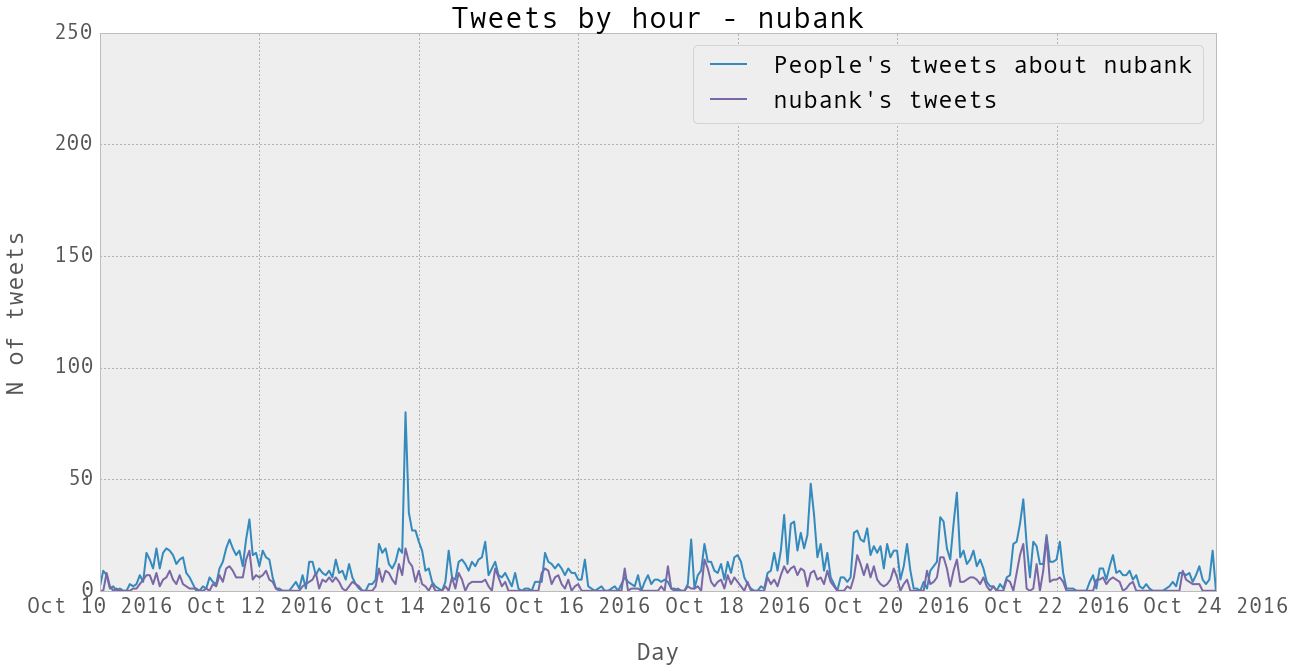

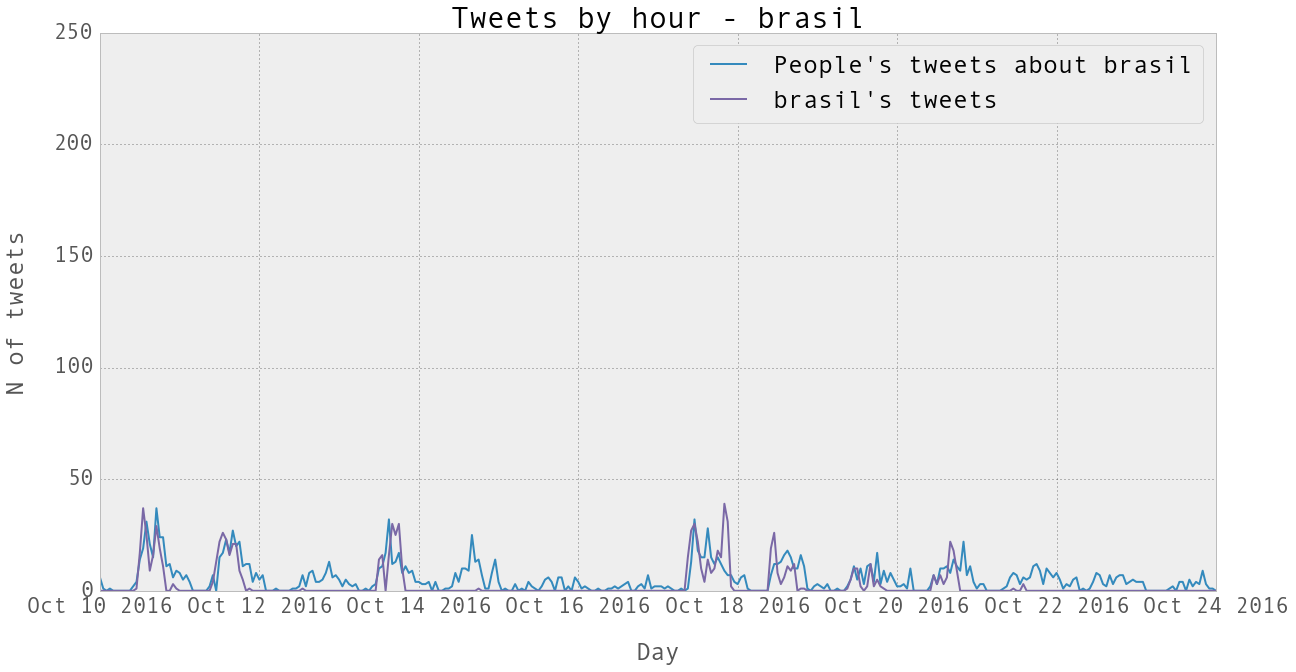

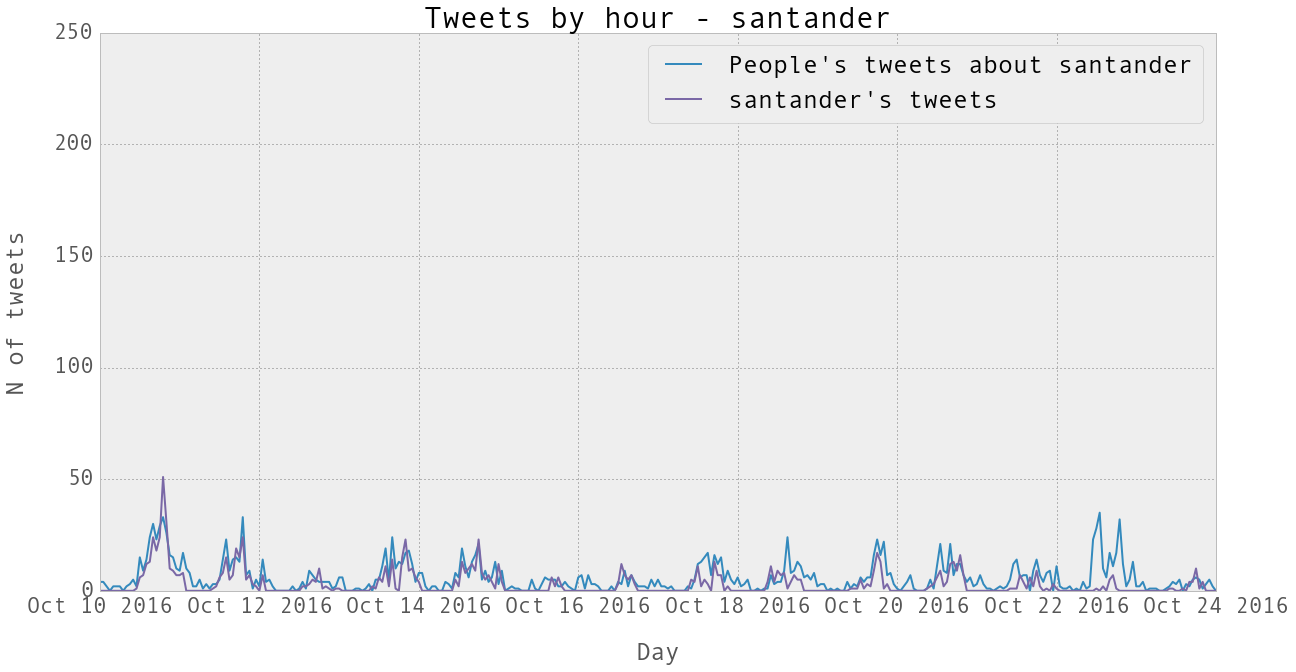

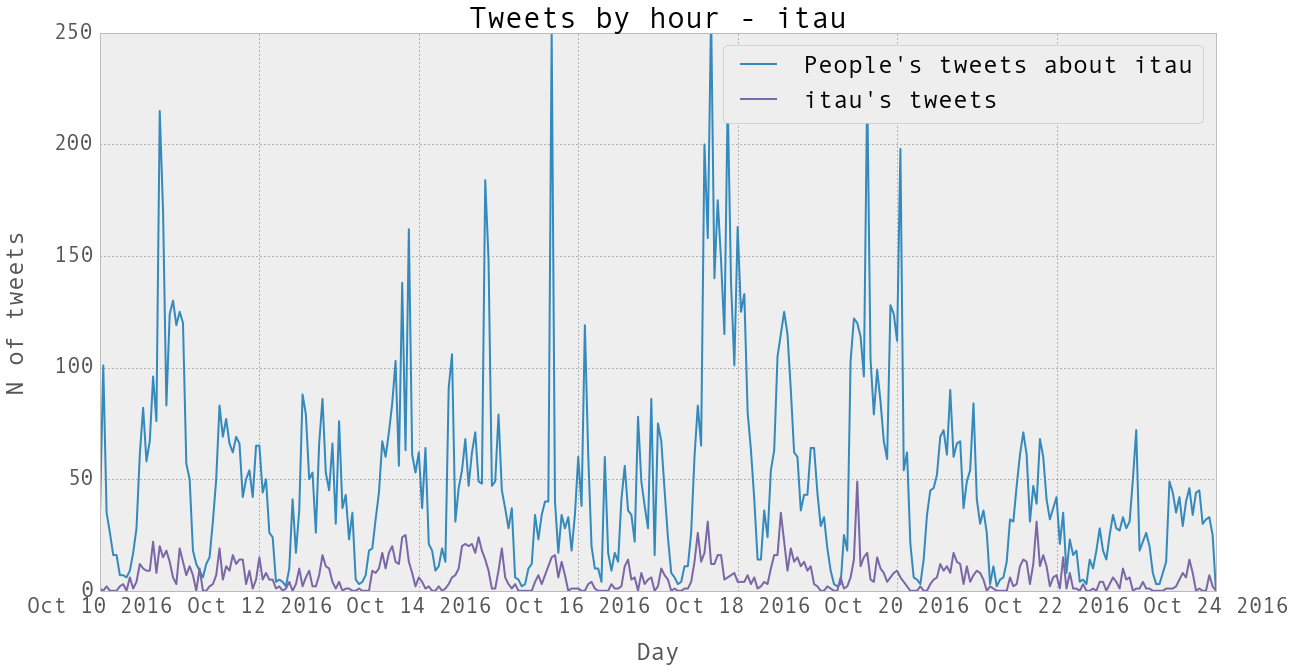

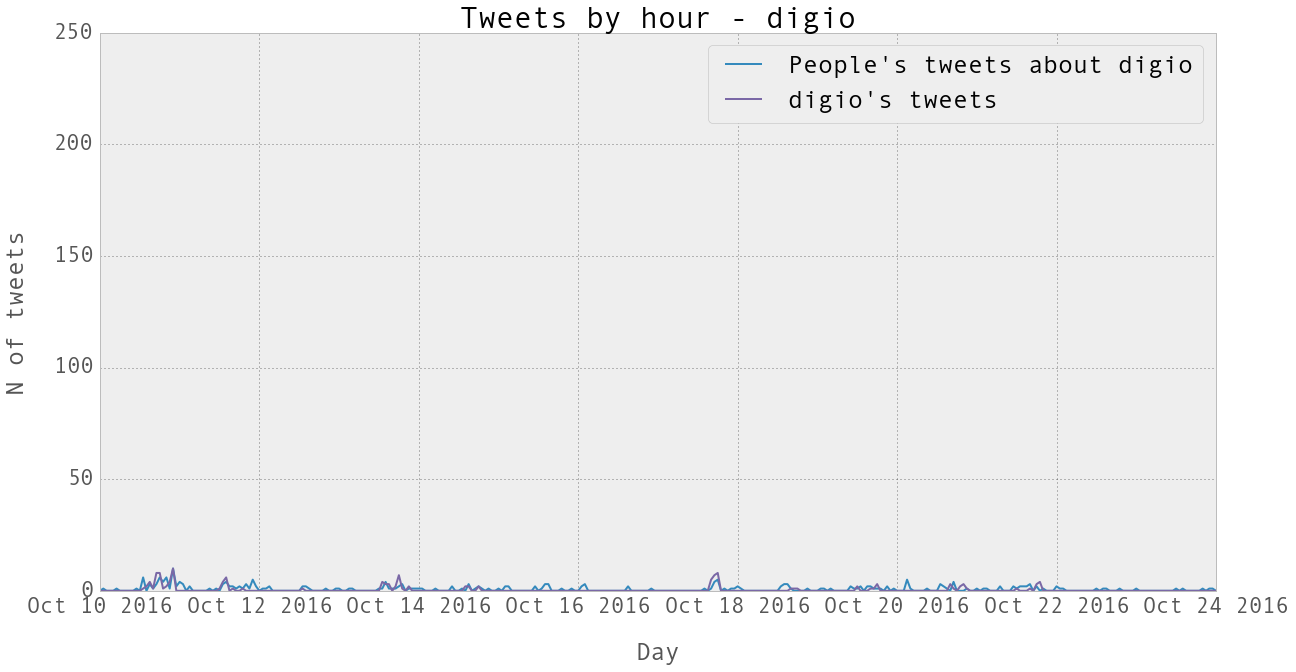

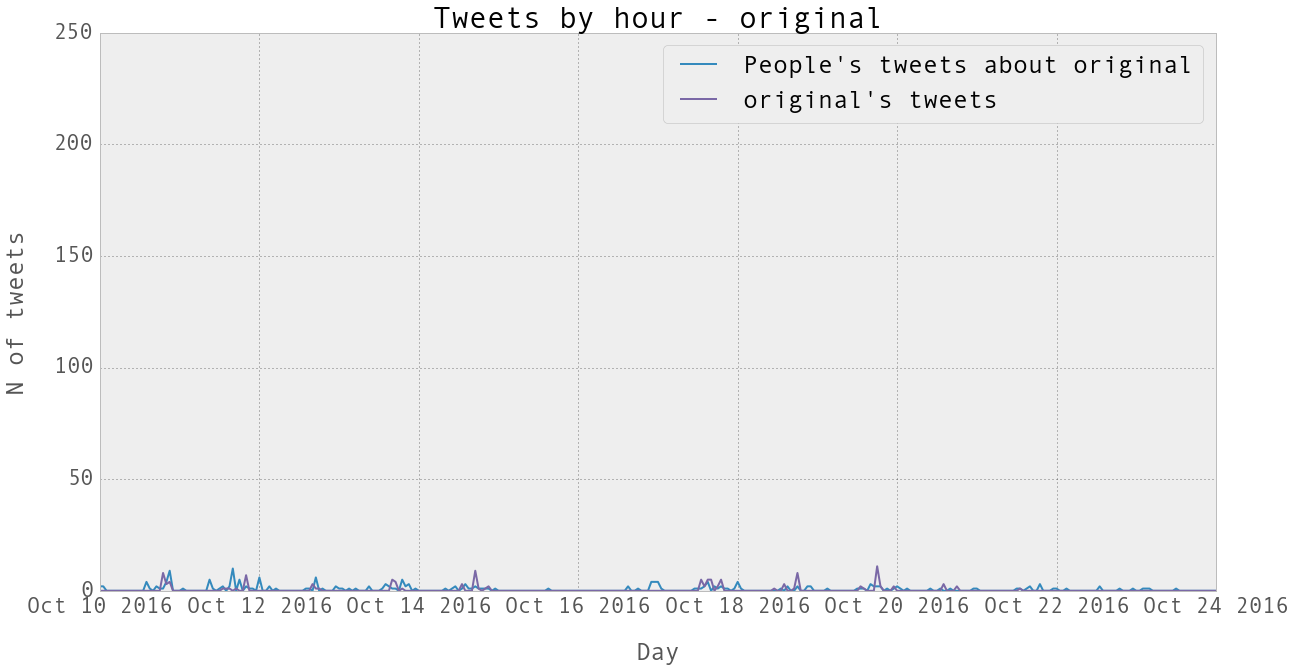

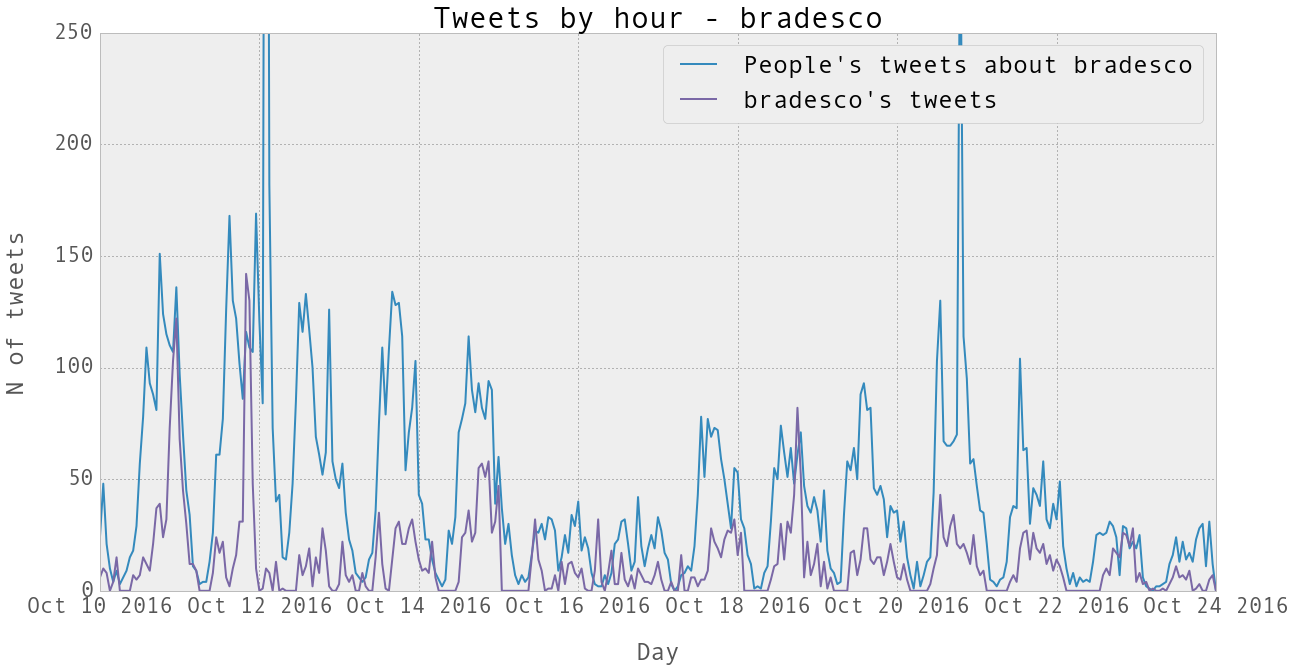

In [161]:
b = ['nubank', 'itau', 'original']
for db in split_dbs:
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(tweets_per_hour.index, tweets_per_hour['other_{}'.format(db)], linewidth=2.0)
    plt.plot(tweets_per_hour.index, tweets_per_hour['bank_{}'.format(db)], linewidth=2.0)
    plt.legend(["People's tweets about {}".format(db), "{}'s tweets".format(db)], fontsize=25);
    plt.xlabel('Day', **labels_par);
    plt.ylim([0, 250])
    plt.ylabel('N of tweets', **labels_par);
    plt.title('Tweets by hour - {}'.format(db), fontsize=30);
    plt.xticks(fontsize=22);
    plt.yticks(fontsize=22);